<head>
    <style>
        .md-typeset h2 {
            margin:0;
            }
        .md-typeset h3 {
            margin:0;
            }
        .jupyter-wrapper table.dataframe tr, .jupyter-wrapper table.dataframe th, .jupyter-wrapper table.dataframe td {
            text-align:left;
            }
        .jupyter-wrapper table.dataframe {
            table-layout: auto;
            }
    </style>
</head>

# Cluster Standard Errors 

In this post, we will show why we need to cluster our standard errors for 
some cases. 

![penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)

In [3]:
if (!require("pacman")) install.packages("pacman")
library(pacman)
p_load(tidyverse, RCurl, data.table, scico, gridExtra, naniar, 
                    scales, miceadds, here, pROC, ROCR, broom, 
                    haven, stargazer,  estimatr, palmerpenguins,
                    plotly)
options(repr.plot.width=9, repr.plot.height=5)  # figsize

## Example penguins 

In [4]:
penguins <- penguins %>% drop_na(sex)
head(penguins)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>
Adelie,Torgersen,39.1,18.7,181,3750,male,2007
Adelie,Torgersen,39.5,17.4,186,3800,female,2007
Adelie,Torgersen,40.3,18.0,195,3250,female,2007
Adelie,Torgersen,36.7,19.3,193,3450,female,2007
Adelie,Torgersen,39.3,20.6,190,3650,male,2007
Adelie,Torgersen,38.9,17.8,181,3625,female,2007


In [55]:
model1 <- lm(body_mass_g ~ bill_length_mm + flipper_length_mm + species,
             data = penguins)
stargazer(model1, type='text',
            no.space=TRUE,
            omit.stat=c('ser', 'f'))


                      Dependent variable:    
                  ---------------------------
                          body_mass_g        
---------------------------------------------
bill_length_mm             60.117***         
                            (7.207)          
flipper_length_mm          27.544***         
                            (3.209)          
speciesChinstrap          -732.417***        
                           (82.063)          
speciesGentoo               113.254          
                           (89.206)          
Constant                 -3,864.073***       
                           (533.592)         
---------------------------------------------
Observations                  333            
R2                           0.824           
Adjusted R2                  0.822           
Note:             *p<0.1; **p<0.05; ***p<0.01


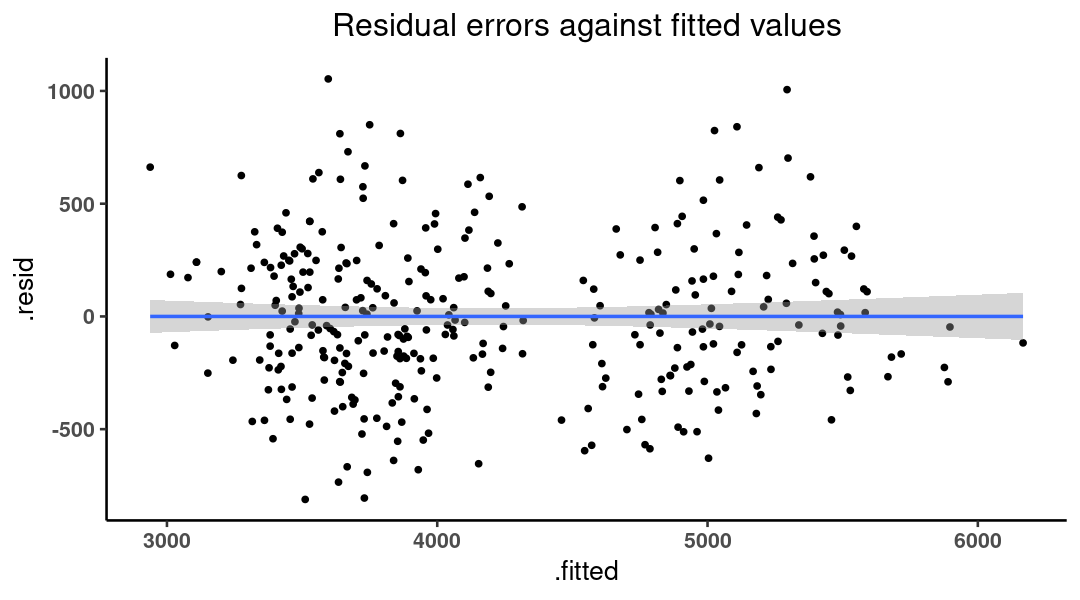

In [20]:
# Plug the original data into the model and find fitted values and
# residuals/errors
fitted_data <- augment(model1, data = penguins)

# Look at relationship between fitted values and residuals
ggplot(fitted_data, aes(x = .fitted, y = .resid)) + 
  geom_point() +
  geom_smooth(formula = y ~ x,method = "lm") + 
  labs(title='Residual errors against fitted values') +
  theme_classic(base_size=16) + 
  theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold')
    )

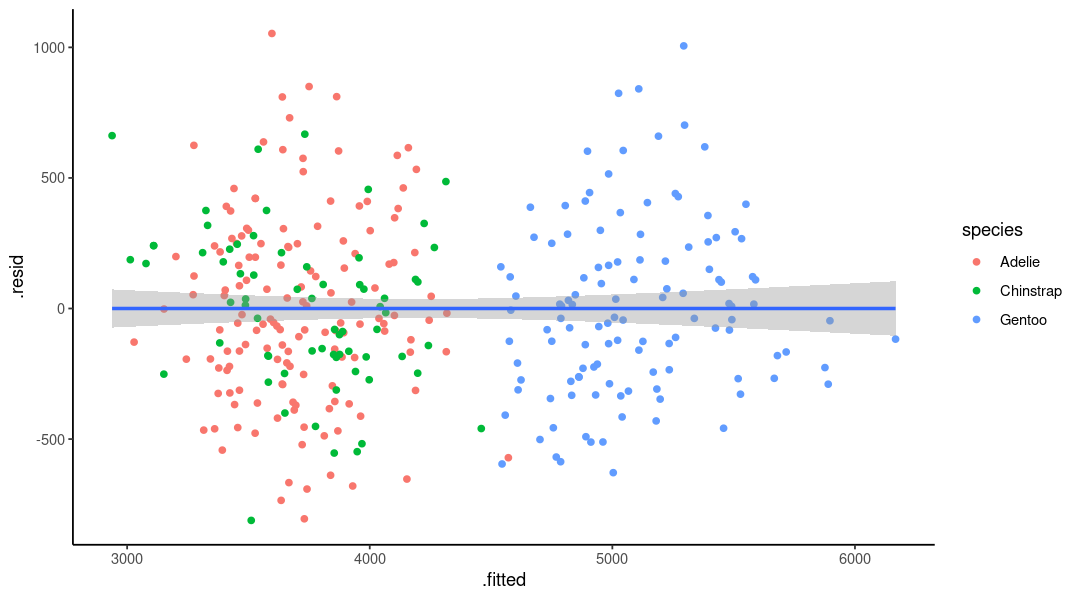

In [34]:
ggplot(fitted_data, aes(x = .fitted, y = .resid)) + 
  geom_point(aes(color = species)) +
  geom_smooth(formula=y ~ x, method = "lm") + 
  theme_classic()

## Why we have clusters? 

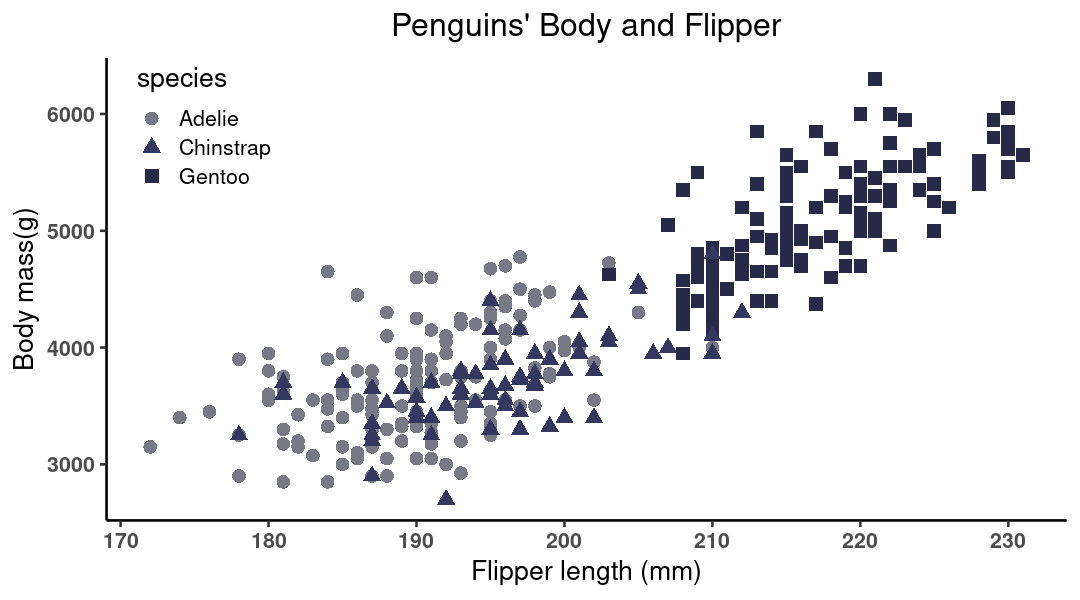

In [14]:
penguins %>%
    ggplot(aes(x=flipper_length_mm, y=body_mass_g)) +
    geom_point(aes(color=species, shape=species), size=3.5) +
    theme_classic(base_size=16) +
    labs(
        x='Flipper length (mm)', y='Body mass(g)',
        title="Penguins' Body and Flipper"
    ) +
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold'),
            legend.position=c(0.1, 0.85)
    ) +
    scale_color_manual(values=c('#777986', '#323860', '#262a48'))

You can see that we have two different _data groups_. Although we used
_dummy variables_ in our regression, the error term is still correlated
with our sample. Therefore, it is better to cluster our residuals and 
calculate standard errors after clustering. 

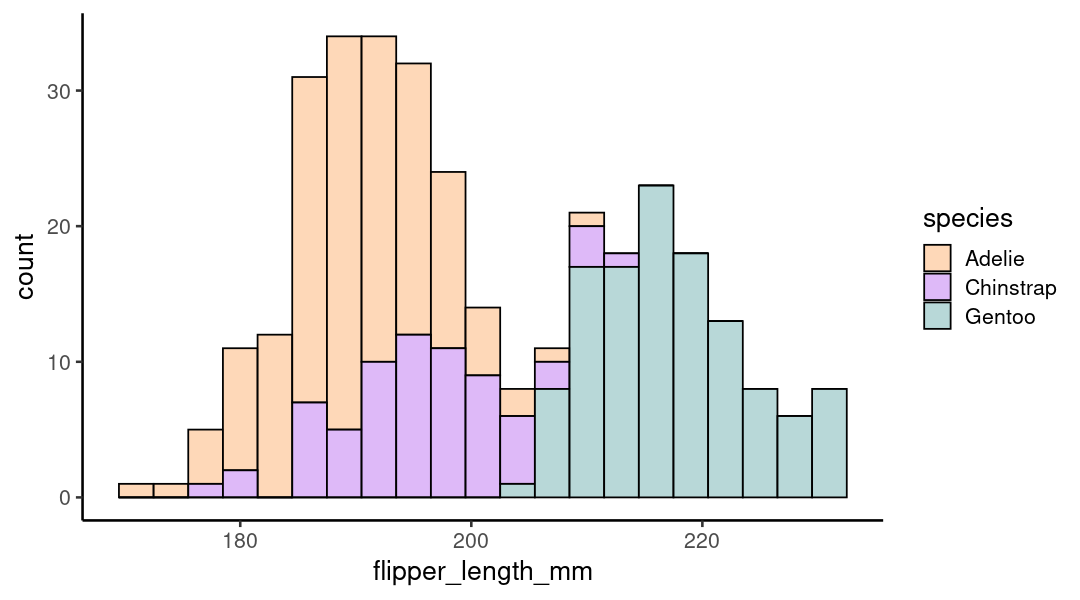

In [50]:
penguins %>%
    ggplot(aes(x=flipper_length_mm, fill=species)) +
    geom_histogram(binwidth=3, alpha=0.7,color='black') +
    theme_classic(base_size=16) +
    scale_fill_manual(values=c('#FEC799', '#D09BF5', '#99C7C7'))

<img src="/math/causal/images/cluster.png">

In [51]:
table(penguins$species)


   Adelie Chinstrap    Gentoo 
      146        68       119 

In [54]:
penguins %>%
    filter(species=='Adelie') -> adelie
penguins %>%
    filter(species=='Chinstrap') -> chinstrap
penguins %>%
    filter(species=='Gentoo') -> gentoo

In [56]:
adelie_reg <- lm(body_mass_g ~ bill_length_mm + flipper_length_mm,
             data = adelie)
chinstrap_reg <- lm(body_mass_g ~ bill_length_mm + flipper_length_mm,
             data = chinstrap)
gentoo_reg <- lm(body_mass_g ~ bill_length_mm + flipper_length_mm,
             data = gentoo)
stargazer(model1, adelie_reg, chinstrap_reg, gentoo_reg, type='text',
            no.space=TRUE,
            omit.stat=c('ser', 'f'))


                                    Dependent variable:                  
                  -------------------------------------------------------
                                        body_mass_g                      
                       (1)           (2)           (3)           (4)     
-------------------------------------------------------------------------
bill_length_mm      60.117***     75.477***     31.243**      56.127***  
                     (7.207)      (11.958)      (11.798)      (13.096)   
flipper_length_mm   27.544***     22.450***     27.675***     36.582***  
                     (3.209)       (4.882)       (5.524)       (6.177)   
speciesChinstrap   -732.417***                                           
                    (82.063)                                             
speciesGentoo        113.254                                             
                    (89.206)                                             
Constant          -3,864.073*** -3,49

## Mathematical motivation

We know that the OLS estimator is


\begin{aligned}
\hat{\beta} & = (X'X)^{-1}X'y = (X'X)^{-1}X'(X\beta+u) \\
            & = \beta + (X'X)^{-1}X'u 
\end{aligned}


This gives,

$$
\hat{\beta}-\beta =  (X'X)^{-1}X'u
$$

Therefore, we could estimate the variance of $\hat{\beta}$

\begin{aligned}
Var(\hat{\beta}) & = E[(\beta - \hat{\beta})(\beta - \hat{\beta})'] \\
                 & = (X'X)^{-1}X' E[uu'] X(X'X)^{-1}
\end{aligned}

Now, denote $E[uu'] = \Omega$, we can have

* $Var(\hat{\beta}) = (X'X)^{-1}X' \Omega  X(X'X)^{-1}$
* $Var(\hat{\beta}) = \sigma^2 (X'X)^{-1}$ when we have the assumption $V(u) = \sigma^2$. 

Given the assumptions that a practitioner deems as reasonable, different types 
of standard errors solve this problem in different ways. For example, 
classic homoskedastic standard errors assume that $\Omega$  is diagonal with 
identical elements $\sigma^{2}$, which simplifies the expression for 
$V({\hat{\beta}})=\sigma^{2}(X'X)^{-1}$. Huber-White standard errors assume
 $\Omega$ is diagonal but that the diagonal value varies, while other types of 
 standard errors (e.g. Newey–West, Moulton SEs, Conley spatial SEs) 
 make other restrictions on the form of this matrix to reduce the number 
 of parameters that the practitioner needs to estimate.

Clustered standard errors assume that $\Omega$ is _block-diagonal_ according to 
the clusters in the sample, with unrestricted values in each block but 
zeros elsewhere. In this case, one can define $X_{c}$ and $\Omega_{c}$ as the 
within-block analogues of $X$ and $\Omega$ and derive the following 
mathematical fact:

$$X'\Omega X=\sum_{c}X_{c}\Omega_{c}X_{c}$$